In [354]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
import numpy as np
import pandas as pd
import os
import sys
from keras.optimizers import Adam
import skimage.io
from multiprocessing import Pool
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import pickle

# Prep and input of data

In [2]:
train_data = 'data/training/earrings'
test_data = 'data/testing/earrings'

In [55]:
def train_data_with_label():
    train_images = []
    for i in tqdm(os.listdir(train_data)):
        path = os.path.join(train_data, i)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (28,28))
        train_images.append([np.array(img)])
#         shuffle(train_images)
    return train_images

def test_data_with_label():
    test_images = []
    for i in tqdm(os.listdir(test_data)):
        path = os.path.join(test_data, i)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (28,28))
        test_images.append([np.array(img)])
    return test_images

In [56]:
# Get the images and put them into np arrays and resize them
testing_images = test_data_with_label()
training_images = train_data_with_label()

100%|██████████| 1000/1000 [00:05<00:00, 174.86it/s]


In [347]:
type(testing_images)

list

In [59]:
# normalize the images
tst_img_data = tst_img_data.astype('float32') / 255.
tr_img_data = tr_img_data.astype('float32') / 255.

In [357]:
tr_img_data.shape

(1000, 28, 28, 3)

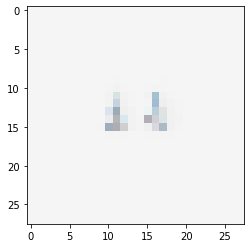

In [195]:
plt.imshow(tr_img_data[999])

In [62]:
# dimensions of our images.
img_width, img_height = 28, 28
img_channel = 3

# CNN Architecture

In [67]:
input_img = Input(shape=(img_width, img_height, img_channel))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [68]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0   

In [69]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [70]:
autoencoder_train = autoencoder.fit(
    tr_img_data, tr_img_data,
    validation_data = (tst_img_data,tst_img_data),
    batch_size=32,
    epochs=50,
    verbose=1,
)

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5679 - val_loss: 0.4115
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4120 - val_loss: 0.3758
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3710 - val_loss: 0.3499
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3425 - val_loss: 0.3241
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3294 - val_loss: 0.3151
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3205 - val_loss: 0.3099
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3139 - val_loss: 0.3039
Epoch 8/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3095 - val_loss: 0.3010
Epoch 9/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3062 - val_loss: 0.2992
Epoch 10/50
1000/1000 [============

In [214]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [353]:
encoder

In [255]:
# encode some digits
# note that we take them from the *test* set
encoded_train_imgs = encoder.predict(tr_img_data)
encoded_test_imgs = encoder.predict(tst_img_data)

In [256]:
encoded_train_imgs.shape

(1000, 4, 4, 8)

In [257]:
encoded_test_imgs.shape

(500, 4, 4, 8)

In [293]:
# flatten the img, so they are the shape (#imgs, height*width*channels of output of encoder)
encoded_train_imgs_flat = encoded_train_imgs.reshape((-1, np.prod(encoded_train_imgs.shape[1:])))
encoded_test_imgs_flat = encoded_test_imgs.reshape((-1, np.prod(encoded_test_imgs.shape[1:])))

In [329]:
encoded_test_imgs_flat.shape

(500, 128)

In [295]:
encoded_test_imgs_flat[0]

array([0.6444786 , 0.5731646 , 0.8859197 , 0.969511  , 2.0689235 ,
       0.64643544, 0.89350593, 0.54326487, 0.9120658 , 0.24917604,
       0.87653476, 0.27672318, 1.936107  , 0.6279447 , 0.5079407 ,
       0.61978215, 0.8402245 , 0.58713865, 0.8905654 , 0.92086613,
       2.6031005 , 0.9322611 , 1.074119  , 0.        , 0.8152442 ,
       0.        , 0.8903912 , 0.5606556 , 1.4162422 , 0.35392877,
       0.13770694, 0.        , 0.33434507, 0.62931776, 0.9532478 ,
       0.8974161 , 2.3765423 , 0.7809754 , 0.93383366, 0.09138253,
       0.6592398 , 0.4950013 , 1.1325015 , 0.20730351, 2.264473  ,
       0.76264155, 0.7257626 , 0.27428675, 0.6356741 , 0.58499295,
       1.0494269 , 0.71765155, 2.7489178 , 0.88151014, 0.8610063 ,
       0.        , 0.4907272 , 0.        , 0.69055605, 0.59709513,
       1.9277807 , 0.28519502, 0.15556185, 0.        , 0.78035235,
       0.69963884, 0.78698283, 0.21881984, 1.9838362 , 0.81817394,
       1.060478  , 0.28189385, 1.0433829 , 0.6401777 , 1.16598

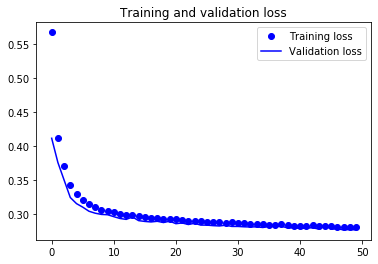

In [297]:
# Training vs Validation Loss Plot
loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation loss and the training loss both are in sync. It shows that your model is not overfitting: the validation loss is decreasing and not increasing, and there rarely any gap between training and validation loss.

# Trying KNN

In [298]:
# Making Training set with the encoded layer
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(encoded_train_imgs_flat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [355]:
# Save the trained model as a pickle string. 
pickle_name = 'jewelry_knn_test.sav'
pickle.dump(knn, open(pickle_name, 'wb')) 

In [348]:
test_img = 7

In [349]:
# Predict KNN for a test image
distances, indices = knn.kneighbors(encoded_test_imgs_flat[test_img].reshape(1, -1))

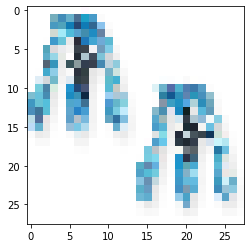

In [350]:
# Print the test image
plt.imshow(tst_img_data[test_img].reshape(28, 28, 3))

In [351]:
# indices for the neighbors in the training data set
indices

array([[332, 459, 568, 478,  64]])

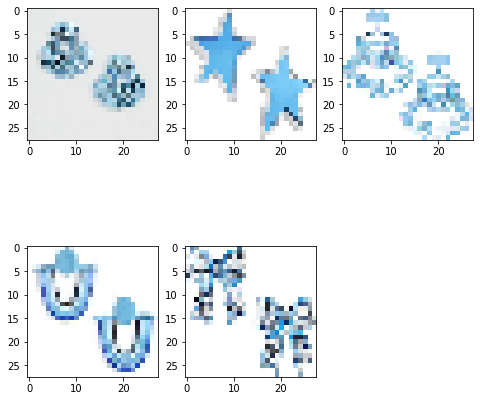

In [352]:
# n_neighbors of the test image
fig= plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i, idx in zip(range(1, columns*rows +1), np.nditer(indices)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(tr_img_data[idx].reshape(28, 28, 3))
plt.show()

# WOOOT